In [25]:
from typing import Callable, Union

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset

from sklearn.model_selection import train_test_split

#### Load MNIST dataset

In [17]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)

In [18]:
x = mnist["data"].to_numpy()
y = mnist["target"].to_numpy()

# normalize data
x = x / 225.0
y = y.astype(int)

y_one_hot = np.zeros((y.size, y.max() + 1))
y_one_hot[np.arange(y.size), y] = 1

print(f"len(x) = {len(x)}")
print(f"len(y) = {len(y)}")

len(x) = 70000
len(y) = 70000


#### Split data

In [19]:
train_sz = 0.80

ratio = 0.15 / 0.05
test_sz = 1 / (1 + ratio)
val_sz = 1 - test_sz

x_train, x_rem, y_train, y_rem = train_test_split(x, y, train_size=train_sz)
x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, test_size=test_sz);

#### Create custom `torch.utils.data.Dataset` for the MNIST data

In [45]:
class MnistDataset(Dataset):
    def __init__(self, torch_x, torch_y):
        self.dataset = TensorDataset(torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.int64))

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __len__(self):
        return len(self.dataset)

... and instantiate the above custom dataset for train/val/test

In [46]:
ds_train = MnistDataset(x_train, y_train)
ds_val = MnistDataset(x_val, y_val)
ds_test = MnistDataset(x_test, y_test)

We also need to define some `torch.utils.data.Dataloader`

In [47]:
def new_dataloader(dataset, batch_size_=64, shuffle_=True):
    return DataLoader(dataset, batch_size=batch_size_, shuffle=shuffle_)

In [48]:
loader_train = new_dataloader(ds_train)
loader_val = new_dataloader(ds_val)
loader_test = new_dataloader(ds_test)

### Now we need a training function and some other stuff

In [59]:
def accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    correct = torch.sum(y_pred.argmax(dim=1) == y_true)
    return correct / y_true.shape[0]

def training_iteration(
    model: nn.Module,
    optimizer: torch.optim,
    loss_fn: Union[Callable, nn.Module],
    loader_train: torch.utils.data.DataLoader,
    device: Union[str, torch.device]
):
    model.train()

    avg_train_loss = 0.0
    avg_train_acc = 0.0

    n_batches = len(loader_train)

    # loop over batches
    for (x_train, y_train) in loader_train:
        x_train, y_train = x_train.to(device), y_train.to(device)

        preds = model(x_train)
        loss = loss_fn(preds, y_train)

        # The classic trio
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_train_loss += loss.item()
        avg_train_acc += accuracy(preds, y_train).item()

    avg_train_loss /= n_batches
    avg_train_acc /= n_batches

    return avg_train_loss, avg_train_acc

def validation_iteration(
    model: nn.Module,
    optimizer: torch.optim,
    loss_fn: Union[Callable, nn.Module],
    loader_val: torch.utils.data.DataLoader,
    device: Union[str, torch.device]
):
    model.eval()
    
    avg_val_loss = 0.0
    avg_val_acc = 0

    n_batches = len(loader_val)

    # no backprop needed!
    with torch.no_grad():

        # loop over batches
        for (x_val, y_val) in loader_val:
            x_val, y_val = x_val.to(device), y_val.to(device)

            preds = model(x_val)
            loss = loss_fn(preds, y_val)
            
            avg_val_loss += loss.item()
            avg_val_acc += accuracy(preds, y_val).item()

    avg_val_loss /= n_batches
    avg_val_acc /= n_batches

    return avg_val_loss, avg_val_acc

In [66]:
def accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    correct = torch.sum(y_pred.argmax(dim=1) == y_true)
    return correct / y_true.shape[0]

def train(
    model: nn.Module,
    optimizer: torch.optim,
    loss_fn: Union[Callable, nn.Module],
    loader_train: torch.utils.data.DataLoader,
    loader_val: torch.utils.data.DataLoader,
    n_epochs: int,
    device: Union[str, torch.device],
    print_every: int
):
    print(f"Using device '{device}'")
    model.to(device)

    train_loss_history = []
    train_acc_history = []

    val_loss_history = []
    val_acc_history = []

    print(f"Training for {n_epochs} epochs.")
    for epoch in range(n_epochs):

        avg_train_loss, avg_train_acc = training_iteration(model, optimizer, loss_fn, loader_train, device)
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(avg_train_acc)

        avg_val_loss, avg_val_acc = validation_iteration(model, optimizer, loss_fn, loader_val, device)
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(avg_val_acc)

        if (epoch == 0) or (epoch % print_every == 0) or (epoch == n_epochs - 1):
            print(
                f"Epoch {epoch + 1}/{n_epochs} | "
                f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f} | "
                f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_acc:.4f}"
            )

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

## Cool, cool, cool, cool. We need an actual Neural Network now...

In [67]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(784, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 10),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.network(x)

In [70]:
model = NeuralNetwork()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = torch.nn.CrossEntropyLoss() # multiclass classification
n_epochs = 10
print_every = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(
                                                                                model=model,
                                                                                optimizer=optimizer,
                                                                                loss_fn=loss_fn,
                                                                                loader_train=loader_train,
                                                                                loader_val=loader_val,
                                                                                n_epochs=n_epochs,
                                                                                device=device,
                                                                                print_every=print_every
                                                                            )

Using device 'cuda'
Training for 10 epochs.
Epoch 1/10 | Train Loss: 1.6046, Train Accuracy: 0.8567 | Val Loss: 1.5495, Val Accuracy: 0.9114
Epoch 2/10 | Train Loss: 1.5349, Train Accuracy: 0.9262 | Val Loss: 1.5427, Val Accuracy: 0.9182
Epoch 3/10 | Train Loss: 1.5311, Train Accuracy: 0.9299 | Val Loss: 1.5185, Val Accuracy: 0.9425
Epoch 4/10 | Train Loss: 1.5280, Train Accuracy: 0.9330 | Val Loss: 1.5224, Val Accuracy: 0.9388
Epoch 5/10 | Train Loss: 1.5338, Train Accuracy: 0.9272 | Val Loss: 1.5252, Val Accuracy: 0.9358
Epoch 6/10 | Train Loss: 1.5307, Train Accuracy: 0.9304 | Val Loss: 1.5331, Val Accuracy: 0.9280
Epoch 7/10 | Train Loss: 1.5213, Train Accuracy: 0.9398 | Val Loss: 1.5452, Val Accuracy: 0.9159
Epoch 8/10 | Train Loss: 1.5243, Train Accuracy: 0.9369 | Val Loss: 1.5169, Val Accuracy: 0.9442
Epoch 9/10 | Train Loss: 1.5221, Train Accuracy: 0.9391 | Val Loss: 1.5187, Val Accuracy: 0.9424
Epoch 10/10 | Train Loss: 1.5239, Train Accuracy: 0.9372 | Val Loss: 1.5274, Val Ac

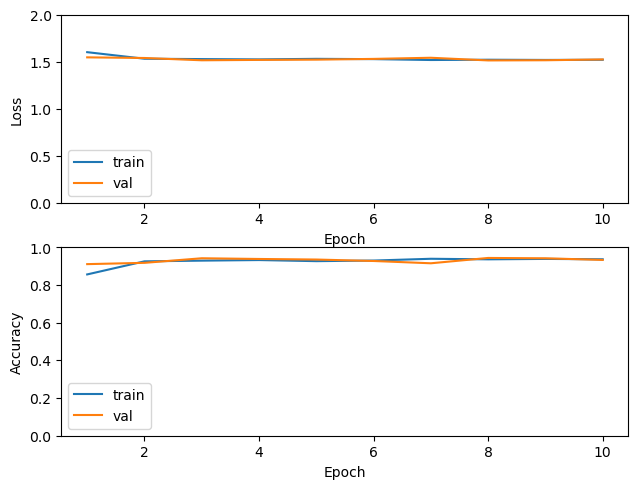

In [76]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.tight_layout()

xs = np.arange(1, n_epochs + 1)

ax1.plot(xs, train_loss_history, label="train")
ax1.plot(xs, val_loss_history, label="val")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_ylim([0, 2])
ax1.legend()

ax2.plot(xs, train_acc_history, label="train")
ax2.plot(xs, val_acc_history, label="val")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_ylim([0, 1])
ax2.legend()

In [81]:
n_correct = 0
n_samples = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
with torch.no_grad():
    for (x_test, y_test) in loader_test:
        x_test, y_test = x_test.to(device), y_test.to(device)
        preds = model(x_test)
        n_correct += (preds.argmax(dim=1) == y_test).sum().item()
        n_samples += y_test.shape[0]

acc = n_correct / n_samples

print(f"Test accuracy: {acc:.3f}.")

Test accuracy: 0.934.


In [140]:
def visualize_prediction(model, loader_test):
    x_test, y_test = next(iter(loader_test))
    x_test, y_test = x_test.to(device), y_test.to(device)

    sample_idx = 0
    
    y_pred = model.forward(x_test[sample_idx : sample_idx + 1])

    # Gotta bring back to CPU otherwise matplotlib.pyplot will be angry at us
    x_test = x_test.to("cpu")
    y_test = y_test.to("cpu")
    y_pred = y_pred.to("cpu").detach()

    plt.imshow(x_test[sample_idx].reshape(28, 28), cmap="gray")
    plt.title(
        f"Prediction: {np.argmax(y_pred)} | True label: {y_test[sample_idx]}"
    )
    plt.axis("off")
    plt.show()

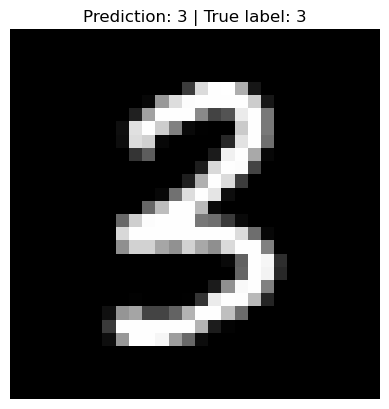

In [141]:
visualize_prediction(model, loader_test)

# Great Success! Very Nice!